In [ ]:
# read in csv
import pandas as pd
headlines_df = pd.read_csv('headline_10000.csv')
headlines_df.head()

,id,title
0,2008-05/aga-pop053008,Prevalence of pre-cancerous masses in the colo...
1,2008-05/e-nfo052708,New form of ECT is as effective as older types...
2,2008-05/jaaj-add050808,Anti-inflammatory drugs do not improve cogniti...
3,2008-05/jaaj-mmw052208,Many men with low testosterone levels do not r...
4,2008-05/jaaj-mot050108,Much of the increased risk of death from smoki...


In [2]:
import spacy

# Tokenize words using spaCy
nlp = spacy.load('en_core_web_sm')

headlines_df['doc_obj'] = headlines_df.title.apply(lambda x: nlp(x))

In [3]:
# function to remove stopwords and punctuation then lemmatize
def remove_punct_stops(doc_object):
    cleaned_tkns_list = [tkn.lemma_ for tkn in doc_object if not tkn.is_punct | tkn.is_stop]
    return ' '.join(cleaned_tkns_list)

In [4]:
# process docs
headlines_df['doc_clean'] = headlines_df.doc_obj.apply(lambda x: remove_punct_stops(x)) 

# bring values into list for later processing
headlines_list = headlines_df.doc_clean.tolist() 


In [5]:
from sklearn.feature_extraction.text import CountVectorizer

# text to vectors using TF
vectorizer = CountVectorizer(ngram_range=(1,2), max_df=.90) 

vecs_tf = vectorizer.fit_transform(headlines_list)
    
vecs_tf.shape

(10000, 53105)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Text to vectors using TFIDF
vectorizer = TfidfVectorizer(max_df=.9, ngram_range=(1,2))
    
vecs_tfidf = vectorizer.fit_transform(headlines_list)
    
vecs_tfidf.shape

(10000, 53105)

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Calculate cosine similarity using third headline as reference
cos_sim_tf = cosine_similarity(vecs_tf[2], vecs_tf)
cos_sim_tfidf = cosine_similarity(vecs_tfidf[2], vecs_tfidf)

# place values into dataframe
headlines_df['cos_sim_tf'] = cos_sim_tf[0]
headlines_df['cos_sim_tfidf'] = cos_sim_tfidf[0]

# make list of top 10 most similar plus reference 
top_n_similar_tf    = headlines_df.nlargest(11, 'cos_sim_tf')   [['title', 'cos_sim_tf'   ]].values.tolist()
top_n_similar_tfidf = headlines_df.nlargest(11, 'cos_sim_tfidf')[['title', 'cos_sim_tfidf']].values.tolist()

In [8]:
from tabulate import tabulate

# Print outputs of both methods to compare
print('ten most similar TF: \n', tabulate(top_n_similar_tf))
print('ten most similar TFIDF: \n', tabulate(top_n_similar_tfidf))

ten most similar TF: 
 -------------------------------------------------------------------------------------------  --------
Anti-inflammatory drugs do not improve cognitive function in older adults                    1
The link between cognitive function and sexuality in older adults                            0.467099
Drug improves cognitive function in mouse model of Down syndrome, Stanford study says        0.414644
Anti-inflammatory drugs ineffective for prevention of Alzheimer's disease                    0.358057
Plant compounds may boost brain function in older adults, study says                         0.313112
Colorectal cancer prevention: A proven benefit of nonsteroidal anti-inflammatory drugs       0.313112
Can training improve memory, thinking abilities in older adults with cognitive impairment?   0.313112
Hazelnuts improve older adults' micronutrient levels                                         0.3114
Non-steroidal anti-inflammatory drugs linked to increased risk of er

In [9]:
import docx

# Save results to a word doc table object
def make_docx_table(top_n_similar_list, value_title, out_file_name):
    w_doc = docx.Document() # create word doc object
    table = w_doc.add_table(rows = 1, cols= len(top_n_similar_list[0]), style='TableGrid') # initialise table

    # Add heading in first row
    row = table.rows[0].cells
    row[0].text = 'Title'
    row[1].text = value_title

    # add data to table
    for title_and_val in top_n_similar_list:
        row = table.add_row().cells

        row[0].text = title_and_val[0]                    # original text
        row[1].text = str(round(title_and_val[1], 2))     # rounded value
    
    # save into document
    w_doc.save(out_file_name)



make_docx_table(top_n_similar_tf, 'Cosine Similarity Values', 'top_n_similar_TF_table.docx')

# Save TF-IDF results to docx table
make_docx_table(top_n_similar_tfidf, 'Cosine Similarity Values', 'top_n_similar_TFIDF_table.docx')

ModuleNotFoundError: No module named 'docx'

# TF Vs. TFIDF
## The reference document could be broken down into three components:
## 1. anti-inflammatory drugs
## 2. cognitive function
## 3. older adults
## These components could be potential topics to explore in the corpus.
## Both methods result in these categories, they have the same top 3 most similar articles. However, TF/IDF method seems to perform better considering we are going to perform topic modelling, it has greater potential to filter out articles that have many components that contain one of the components from the reference document.

In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
import scipy
from scipy import stats
from scipy.stats import zscore

# K-means Clustering
def analyze_clusters(k, vec_data, n_samples_per_clust):
    # initialize kmeans model
    kmeans = KMeans(n_clusters=k,random_state=0, init = 'k-means++', n_init=10, max_iter=200)

    # normalize matrix
    transformer = Normalizer().fit(vec_data)
    norm_vecs = transformer.transform(vec_data)
    #norm_vecs = stats.zscore(vec_data, axis = 1, ddof = 1)

    # fit model to data
    kmeans_fit = kmeans.fit(norm_vecs)

    # place cluster assignnments into dataframe
    headlines_df['km_cluster_labels'] = kmeans_fit.labels_

    # place distance to centroid in df
    #headlines_df['distance'] = kmeans_fit.cluster_centers_
    
    #print(kmeans_fit.transform(norm_vecs))
    #print(len(kmeans_fit.transform(norm_vecs)))

    # print number of articles in each cluster
    clust_nums = []
    for clust in np.sort(headlines_df.km_cluster_labels.unique()):
        clust_nums.append([clust, 
            headlines_df[headlines_df['km_cluster_labels']==clust].shape[0]])
    print(tabulate(clust_nums, headers=['cluster', 'count']))

    # print sample of titles for each cluster
    clust_samp = []
    for clust in np.sort(headlines_df.km_cluster_labels.unique()):
        clust_samp.append(['cluster_{}'.format(clust),
                            headlines_df[headlines_df['km_cluster_labels'] == clust]['title'].sample(n=n_samples_per_clust).values])
    print(tabulate(clust_samp))

    # save samples to file
    with open('view_samples.txt','w') as f:
        f.write(tabulate(clust_samp))
        


    return norm_vecs

analyze_clusters(3, vecs_tfidf, 2)

  cluster    count
---------  -------
        0     7660
        1     1183
        2     1157
---------  -------------------------------------------------------------------------------------------------
cluster_0  ['Less than 1 percent of UK public research funding spent on antibiotic research in past 5 years'
            "Study compares countries' mortality rates after aneurysm surgery"]
cluster_1  ['Traffic noise increases the risk of having a stroke'
            'Mediterranean diet counteracts a genetic risk of stroke, study reports']
cluster_2  ['UCLA researchers find a wide variation in costs to treat low-risk prostate cancer'
            'Off-the-shelf cancer detection']
---------  -------------------------------------------------------------------------------------------------


<10000x53105 sparse matrix of type '<class 'numpy.float64'>'
	with 145153 stored elements in Compressed Sparse Row format>

processing for 2 clusters
processing for 3 clusters
processing for 4 clusters
processing for 5 clusters
processing for 6 clusters
processing for 7 clusters
processing for 8 clusters
processing for 9 clusters
processing for 10 clusters
processing for 11 clusters
processing for 12 clusters
processing for 13 clusters
processing for 14 clusters
processing for 15 clusters


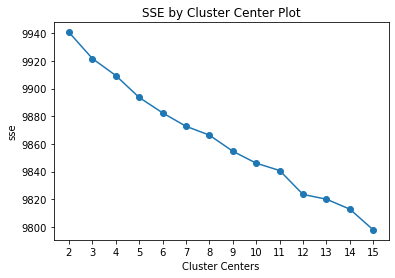

In [36]:
import matplotlib.pyplot as plt

# Find optimal number of clusters
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 1)
    
    sse = []
    for k in iters:
        print('processing for {} clusters'.format(k))
        kmeans_model = KMeans(n_clusters=k,random_state=0, init = 'k-means++', n_init=10, max_iter=200).fit(data)
        sse.append(kmeans_model.inertia_)
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('sse')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(norm_vecs,15)

In [11]:
# Using the elbow method, k = 12 appears to be a potentially optimal number of clusters
analyze_clusters(12, vecs_tfidf, 10)

  cluster    count
---------  -------
        0     5050
        1      473
        2      700
        3      611
        4      741
        5      518
        6      227
        7      437
        8      288
        9      412
       10       95
       11      448
----------  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
cluster_0   ['Thirty years of fast food: Greater variety, but more salt, larger portions, and added calories'
             "No benefit from addition of aliskiren to 'gold standard' ACE inhibitor"
             'Freeway air bad for mouse brain'
             'UPMC-developed test rapidly, accurately profiles genetics and treatment of brain tumors'
             'Patients at risk over failure to recognize important diabetes subtype'
             'Does payer type -- commercial insurance or Medicare -- affect the use of low-value

<10000x53105 sparse matrix of type '<class 'numpy.float64'>'
	with 145153 stored elements in Compressed Sparse Row format>

In [14]:
from sklearn.decomposition import LatentDirichletAllocation

# Latent Dirichlet Allocation 
n_topics = 8
n_features = 1000

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features,stop_words='english')
tf = tf_vectorizer.fit_transform(headlines_list)
tf_feature_names = tf_vectorizer.get_feature_names()

lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online', learning_offset=50, random_state=0)
lda_z = lda.fit_transform(tf)

In [15]:
# Display top 10 words for each topic

def display_topics(model, feature_names, no_top_words):
    topic_words = []
    for topic_idx, topic in enumerate(model.components_):
        # print topic word
        #print("Topic %d:" % (topic_idx))
        
        top_words = " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])

        #print(" ".join(top_words))

        topic_words.append((topic_idx, top_words))
    return topic_words

no_top_words = 10

display_topics(lda, tf_feature_names, no_top_words)



[(0, 'drug study new use stroke long lancet infection hiv term'),
 (1, 'surgery benefit early cancer patient test predict people brain life'),
 (2, 'study research new trial woman child reveal lung clinical symptom'),
 (3,
  'patient cancer new treatment improve researcher breast help therapy identify'),
 (4, 'old diabetes adult kidney weight diet lead type loss healthy'),
 (5, 'child high risk blood cancer 19 covid death rate sleep'),
 (6, 'risk link heart disease increase high low death young associate'),
 (7,
  'health care study disorder effect mental dementia reduce diagnosis vaccine')]

In [ ]:
topic_words = display_topics(lda, tf_feature_names, 6)
topic_words

'--  -----------------------------------------------------------------------------\n 0  reduce year death failure medication dementia diabetes lancet heart pregnancy\n 1  cancer patient treatment breast improve prostate survival therapy test woman\n 2  child study depression weight diet childhood teen loss poor healthy\n 3  study surgery benefit patient trial new lung clinical suggest need\n 4  help woman prevent treat genetic obesity cell gene disorder syndrome\n 5  use long early hospital study term symptom opioid test life\n 6  kidney life good chronic exercise birth disease patient diagnosis quality\n 7  new drug adult study researcher research old identify people hiv\n 8  health care patient covid 19 diabete outcome injury pain improve\n 9  brain age alcohol relate vaccine vitamin study cognitive result response\n10  high blood rate study stroke link antibiotic pressure activity physical\n11  risk link disease increase heart high death low attack alzheimer\n--  -------------------